In [14]:
import sys
sys.path.append('../../data')
sys.path.append('../../')

In [15]:
from lib import transformers, data
import numpy as np

# Loading the data

In [16]:
from random import sample
from pathlib import Path

movies = data.load_data(Path('../../data/'))

Loading title basics...


/home/constantine/Documents/DM/imdb_mvp_repository/mvp-mlpractico/mlp_mvp/arquitectura/ml_env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Loading title ratings...
Loading movie directors...
Merging everything...


In [17]:
movies.head(5)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes,director
0,tt0000009,movie,Miss Jerry,Miss Jerry,0,1894.0,\N,45.0,[Romance],5.9,154,nm0085156
1,tt0000147,movie,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,0,1897.0,\N,20.0,"[Documentary, News, Sport]",5.2,356,nm0714557
2,tt0000502,movie,Bohemios,Bohemios,0,1905.0,\N,100.0,[no-genre],3.8,6,nm0063413
3,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906.0,\N,70.0,"[Biography, Crime, Drama]",6.1,589,nm0846879
4,tt0000679,movie,The Fairylogue and Radio-Plays,The Fairylogue and Radio-Plays,0,1908.0,\N,120.0,"[Adventure, Fantasy]",5.2,37,nm0091767


In [18]:
train_df = movies[movies.startYear <= 2017]
test_df = movies[movies.startYear > 2017]

len(train_df), len(test_df), len(test_df) / len(train_df)

(271845, 21170, 0.07787525979878239)

## Convierto de DF a puro

In [19]:
y_train = train_df.averageRating
y_test = test_df.averageRating

X_train = train_df.to_dict(orient='records')
X_test = test_df.to_dict(orient='records')

In [20]:
X_train[1]

{'tconst': 'tt0000147',
 'titleType': 'movie',
 'primaryTitle': 'The Corbett-Fitzsimmons Fight',
 'originalTitle': 'The Corbett-Fitzsimmons Fight',
 'isAdult': 0,
 'startYear': 1897.0,
 'endYear': '\\N',
 'runtimeMinutes': 20.0,
 'genres': ['Documentary', 'News', 'Sport'],
 'averageRating': 5.2,
 'numVotes': 356,
 'director': 'nm0714557'}

# Modelling per se

### Armamos todos los problemas de clasificacion

In [21]:
thresholds = np.linspace(1.5, 9.5, 15)
thresholds

array([1.5       , 2.07142857, 2.64285714, 3.21428571, 3.78571429,
       4.35714286, 4.92857143, 5.5       , 6.07142857, 6.64285714,
       7.21428571, 7.78571429, 8.35714286, 8.92857143, 9.5       ])

In [22]:
# Para graficar
# El punto medio entre cada par de threshold, util para graficar
mids = [(t0 + t1)/2 for t0, t1 in zip(thresholds[:-1], thresholds[1:])]

In [23]:
mids

[1.7857142857142856,
 2.3571428571428568,
 2.928571428571429,
 3.5,
 4.071428571428571,
 4.642857142857142,
 5.214285714285714,
 5.785714285714286,
 6.357142857142857,
 6.928571428571428,
 7.5,
 8.071428571428571,
 8.642857142857142,
 9.214285714285714]

# Contruyo un Target que de acuerdo a un threshold me dice si mi rating es True o False 
(es decir, true si target <= threshold) , acá use los threshold, pero no los mids

In [24]:
def get_bools(y):
    res = []
    for t in thresholds:
        res.append(y <= t)
    return res

ys_train = get_bools(y_train)
ys_test = get_bools(y_test)

In [25]:
ys_train?

Type:        list
String form:
[0         False
           1         False
           2         False
           3         False
           4         False
           ...
           <...> ue
           292993    True
           292995    True
           293018    True
           Name: averageRating, Length: 271845, dtype: bool]
Length:      15
Docstring:  
Built-in mutable sequence.

If no argument is given, the constructor creates a new empty list.
The argument must be an iterable if specified.


In [26]:
X_train[1], " - ",y_train[1] , thresholds[1], ys_train[0]

({'tconst': 'tt0000147',
  'titleType': 'movie',
  'primaryTitle': 'The Corbett-Fitzsimmons Fight',
  'originalTitle': 'The Corbett-Fitzsimmons Fight',
  'isAdult': 0,
  'startYear': 1897.0,
  'endYear': '\\N',
  'runtimeMinutes': 20.0,
  'genres': ['Documentary', 'News', 'Sport'],
  'averageRating': 5.2,
  'numVotes': 356,
  'director': 'nm0714557'},
 ' - ',
 5.2,
 2.071428571428571,
 0         False
 1         False
 2         False
 3         False
 4         False
           ...  
 292991    False
 292992    False
 292993    False
 292995    False
 293018    False
 Name: averageRating, Length: 271845, dtype: bool)

### Armamos los modelos

In [27]:
# !apt-get install swig -y
# !pip install Cython numpy

# !pip install auto-sklearn
# !pip uninstall tornado -y
# !pip install tornado==6.0.3
# !pip install tornado

## transformers.algo Hace referencia a la libreria de transformers, que esta en lib, con esto habilito features

In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import make_union, make_pipeline
from sklearn.feature_extraction import DictVectorizer

import autosklearn.classification
from autosklearn.metrics import roc_auc

def get_features_pipe(
        use_years: bool, use_genre: bool, 
        use_director: bool, director_kws: dict=None, post_processing=None):
    """
    Construye el pipeline de features de forma parametrizada
    """
    # director_kws solo tiene sentido cuando use_director=True. 
    # Esto nos va a traer dolores de cabeza a la hora de explorar el espacio de hyper parametros
    # TODO: esto debería permitir cachear los datasets transformados
    
    steps = []
    if use_years:
        steps.append(make_pipeline(transformers.YearsAgo(), DictVectorizer(sparse=False)))
    
    if use_genre:
        steps.append(make_pipeline(transformers.GenreDummies(), DictVectorizer(sparse=False)))
        
    if use_director:
        director_kws = director_kws or {}
        # cuando hacemos **director_kws usamos ese diccionario para pasar parametros
        steps.append(make_pipeline(transformers.DirectorFeatures(**director_kws), DictVectorizer(sparse=False)))
    
    res = make_union(*steps)
    if post_processing:
        res = make_pipeline(res, post_processing)
    return res

def get_model_pipe(features_pipe, estimator):
    return make_pipeline(features_pipe, estimator)

/home/constantine/Documents/DM/imdb_mvp_repository/mvp-mlpractico/mlp_mvp/arquitectura/ml_env/lib/python3.8/site-packages/pyparsing.py:3190: FutureWarning: Possible set intersection at position 3
  self.re = re.compile(self.reString)


In [29]:
model = get_model_pipe(
    features_pipe=get_features_pipe(
        use_years=False, use_director=True, use_genre=True, post_processing=StandardScaler()
    ),
    estimator=LogisticRegression()   
)

model

Pipeline(memory=None,
         steps=[('pipeline',
                 Pipeline(memory=None,
                          steps=[('featureunion',
                                  FeatureUnion(n_jobs=None,
                                               transformer_list=[('pipeline-1',
                                                                  Pipeline(memory=None,
                                                                           steps=[('genredummies',
                                                                                   GenreDummies()),
                                                                                  ('dictvectorizer',
                                                                                   DictVectorizer(dtype=<class 'numpy.float64'>,
                                                                                                  separator='=',
                                                                                          

In [30]:
models = [
    get_model_pipe(
        features_pipe=get_features_pipe(
            use_years=False, use_director=True, use_genre=True, post_processing=StandardScaler()
        ),
#         model=LogisticRegression()
        estimator=LogisticRegression() 
    )
    for _ in range(len(thresholds))
]

In [31]:
# miro el 1er pipe
models[1]

Pipeline(memory=None,
         steps=[('pipeline',
                 Pipeline(memory=None,
                          steps=[('featureunion',
                                  FeatureUnion(n_jobs=None,
                                               transformer_list=[('pipeline-1',
                                                                  Pipeline(memory=None,
                                                                           steps=[('genredummies',
                                                                                   GenreDummies()),
                                                                                  ('dictvectorizer',
                                                                                   DictVectorizer(dtype=<class 'numpy.float64'>,
                                                                                                  separator='=',
                                                                                          

### Entrenamos

In [32]:
for i, m in enumerate(models):
    print(i)
    m.fit(X_train, ys_train[i])

0
1
2


/home/constantine/Documents/DM/imdb_mvp_repository/mvp-mlpractico/mlp_mvp/arquitectura/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


3
4
5
6
7
8
9
10
11
12
13
14


/home/constantine/Documents/DM/imdb_mvp_repository/mvp-mlpractico/mlp_mvp/arquitectura/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Visualizamos los modelos

In [33]:
import matplotlib.pyplot as plt
import pandas as pd
from random import randint

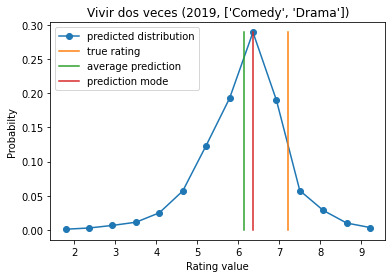

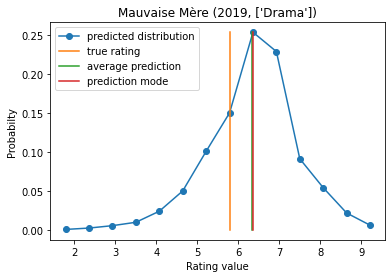

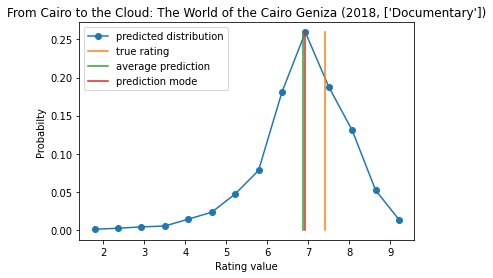

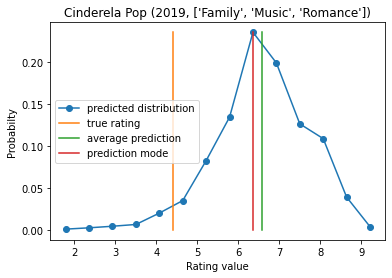

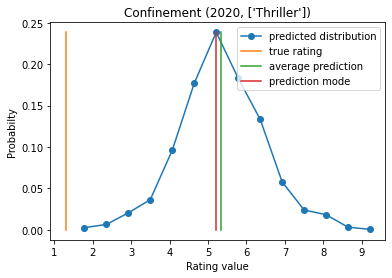

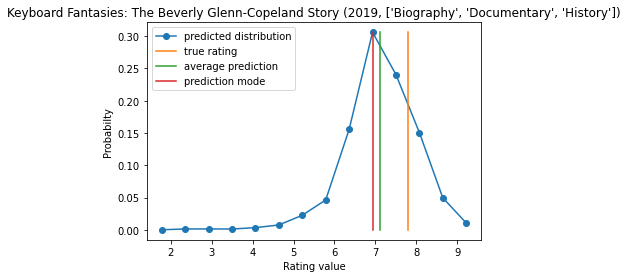

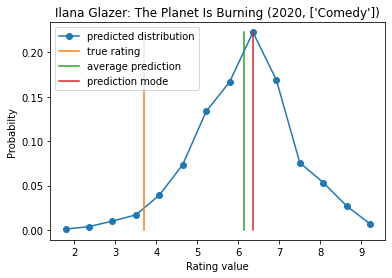

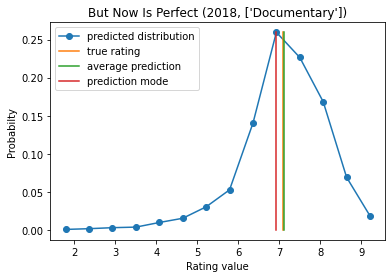

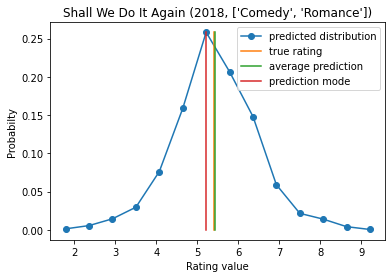

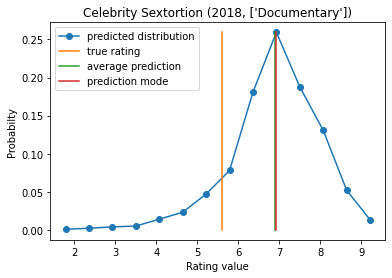

In [34]:
dt = X_test
y_dt = y_test

for _ in range(10):
    i = randint(0, len(dt))

    plt.figure()
    plt.title('{originalTitle} ({startYear:.00f}, {genres})'.format(**dt[i]))
    preds = np.asarray([m.predict_proba([dt[i]])[0,1] for m in models])
    preds = preds[1:] - preds[:-1]

    plt.plot(mids, preds, '-o', label='predicted distribution')
    plt.plot([y_dt.iloc[i], y_dt.iloc[i]], [0, preds.max()], label='true rating')
    plt.plot([(preds * mids).sum(), (preds * mids).sum()], [0, preds.max()], label='average prediction')
    plt.plot([mids[preds.argmax()], mids[preds.argmax()]], [0, preds.max()], label='prediction mode')
    plt.legend(loc='best')
    plt.xlabel('Rating value')
    plt.ylabel('Probabilty')

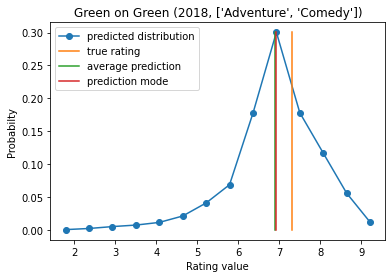

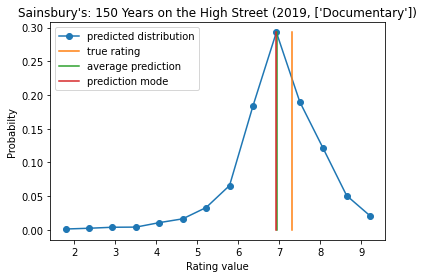

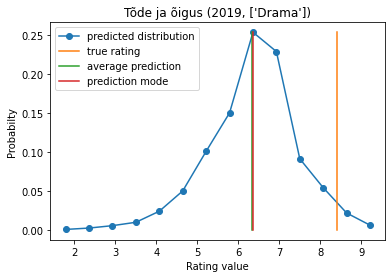

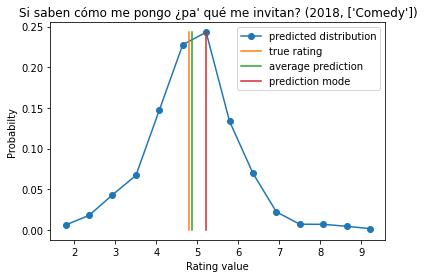

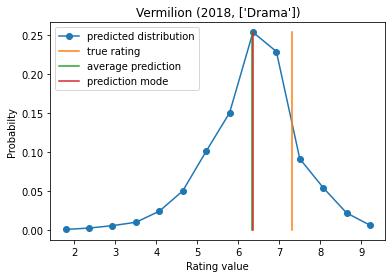

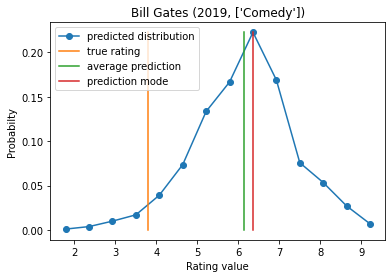

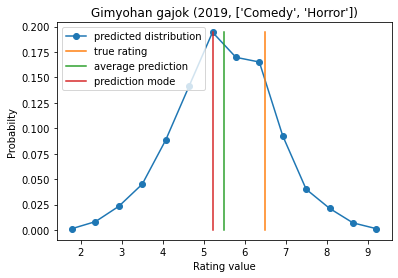

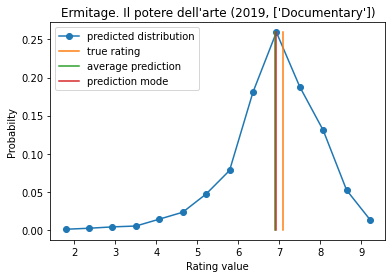

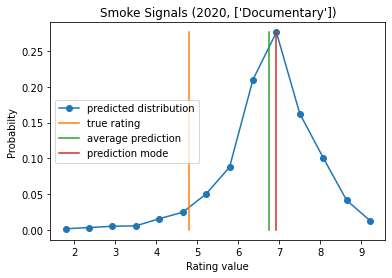

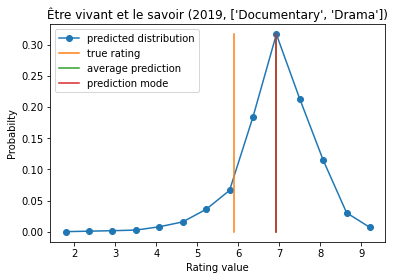

In [35]:
dt = X_test
y_dt = y_test

for _ in range(10):
    i = randint(0, len(dt))

    plt.figure()
    plt.title('{originalTitle} ({startYear:.00f}, {genres})'.format(**dt[i]))
    preds = np.asarray([m.predict_proba([dt[i]])[0,1] for m in models])
    preds = preds[1:] - preds[:-1]

    plt.plot(mids, preds, '-o', label='predicted distribution')
    plt.plot([y_dt.iloc[i], y_dt.iloc[i]], [0, preds.max()], label='true rating')
    plt.plot([(preds * mids).sum(), (preds * mids).sum()], [0, preds.max()], label='average prediction')
    plt.plot([mids[preds.argmax()], mids[preds.argmax()]], [0, preds.max()], label='prediction mode')
    plt.legend(loc='best')
    plt.xlabel('Rating value')
    plt.ylabel('Probabilty')
    

# Para pensar

Pensando en el contexto de querer brindar una herramienta que guie la construccion de guiones

* Nos da algún tipo de ventaja para construir un mejor producto esta técnica?
* Qué metrica offline podemos usar para evaluar este modelo?
* Habría una ventaja de utilizar un modelo basado en arboles?
* Para leer: Cómo se podría empaquetar este código en algo compatible con sklearn.linear_models.LogisticRegression? 